In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import scipy.io

check_gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if check_gpu \
      else "NOT AVAILABLE" )

#tipos de datos 
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)   #establece el tipo de float predeterminado

GPU is available


# Static Model
Referencia: Capítulo 5 "Deep Learning in Computational Mechanics: An introductory Course". Stefan Kollmannsberger. 

Modelo lineal de barra elástica unidimensional estática

1. $$\dfrac{d}{dx} \left(EA\dfrac{du}{dx}\right) + p = 0 \hspace{0.8cm}  \text{en }\, \Omega,$$

2. $$EA\dfrac{du}{dx} = F \hspace{0.8cm}  \text{en }\, \Gamma_N $$

2. $$u = g \hspace{0.8cm}  \text{en }\, \Gamma_D $$

El módulo de Young $E(x)$ y el área de la sección transversal $A(x)$ pueden variar con respecto a x.

## Ejemplo

Considere $\Omega = [0,1]$, $\Gamma_D = \{ x \,|\, x = 0, x = 1\}$ y $\Gamma_N = \emptyset$. Los parámetros del material satisfacen $EA = 1$. La solución elegida para el desplazamiento viene dada por 

$$u(x) = \sin(2\pi x)$$

que, después de reemplazarla en (1), resulta la carga distribuida 

$$p(x) = 4\pi^2 \sin(2\pi x).$$ 

Además las condiciones de dirichlet vienen dadas por $u(0) = u(1) = 0$.


## Enfoque PINNs 

## Enfoque PINNs 
Considere los siguientes conjuntos:

* $\{x_j^{f}\}_{j=1}^{N_f}$ un conjunto de puntos en el interior de $\Omega$.

* $\{x_j^{b}\}_{j=1}^{N_b}$ un conjunto de puntos en $\Gamma_D$. 




Sea ${u}_{NN}(x; \vec{\theta})$ una red neuronal feed-forward con una neurona de entradas, una neurona de salida, $L$ capas ocultas de $N_L$ neuronas en cada capa oculta. El enfoque PINNs sostiene que la solución del problema 1-2-3 se reduce a determinar los pesos y sesgos (vector $\vec{\theta}$) de la red ${u}_{NN}$ que minimiza la siguiente función de pérdida:


$$\mathcal{L}(\vec{\theta}) =  \mathcal{L}_f(\vec{\theta}) + \mathcal{L}_{b}(\vec{\theta})$$


donde 

$$\mathcal{L}_f(\vec{\theta}) = \dfrac{1}{N_f}\sum_{j = 1}^{N_f} \left(\dfrac{d}{dx} \left(EA \dfrac{d}{dx} u_{NN} (x_j^f) \right)  + p(x_j^f)\right)^2,$$

$$\mathcal{L}_{b}(\vec{\theta}) = \dfrac{1}{N_b}\sum_{j = 1}^{N_b}  \left(u_{NN}(x_j^{b}) - 0  \right)^2.$$


### Dominios

In [5]:
xmin = 0
xmax = 1
#puntos de colocación
X_f = tf.constant(xmin + (xmax-xmin)*np.random.rand(100,1), dtype=DTYPE)
#puntos de borde
X_b = tf.constant([[xmin],[xmax]], dtype=DTYPE)

### Red Feed-Forward

In [51]:
#Red Neuronal
def init_model(num_hidden_layers = 2, num_neurons_per_layer = 20 ):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(1))  #una neurona de input

    for _ in range(num_hidden_layers):  #capas ocultas
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, 
                                        activation = tf.keras.activations.get('tanh'),
                                       kernel_initializer = 'glorot_normal'))
    
    model.add(tf.keras.layers.Dense(1))  #una neurona de output
    return model

In [8]:
model_1 = init_model()

### Derivada de la red con respecto al input

In [50]:
def get_derivate(model, X):
    with tf.GradientTape() as outer_tape:
        outer_tape.watch(X)
        with tf.GradientTape() as inner_tape:
            inner_tape.watch(X)
            u = model(X)
        du_dx = inner_tape.gradient(u, X) #primera derivada de u respecto a x
    ddu_ddx = outer_tape.gradient(du_dx, X)  #segunda derivada de u respecto a x
    return ddu_ddx, du_dx, u

In [14]:
#get_derivate(model_1, X_f)

### PINNs

In [15]:
def f(model_1, X):
    ddu_ddx, _, _ = get_derivate(model_1, X_f)
    p = 4.0 * np.pi**2 * tf.sin(2.0*np.pi*X)
    return ddu_ddx + p

In [18]:
#f(model_1, X_f)

### Función de Perdida

In [20]:
def compute_loss(model, X, X_):
    f_ = f(model, X)
    loss_f = tf.reduce_mean(tf.square(f_))
    loss_b = tf.reduce_mean(tf.square(model(X_) - 0.0)) 

    loss = loss_f + loss_b
    return loss, loss_f, loss_b


In [22]:
#compute_loss(model_1, X_f, X_b)

### Derivada de la función de Pérdida con respecto a los pesos y sesgos de la red

In [52]:
def get_derivate_loss(model, X, X_):
    with tf.GradientTape() as tape:
        loss, loss_f, loss_b = compute_loss(model, X, X_)
    grads = tape.gradient(loss, model.trainable_variables) #gradiente de la función de pérdida con respecto a los pesos de la red
    return grads, loss, loss_f, loss_b

In [25]:
#get_derivate_loss(model_1, X_f, X_b)

### Entrenamiento

In [42]:
model_1 = init_model()

In [43]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step(model, X, X_):
    grads, loss, loss_f, loss_b = get_derivate_loss(model, X, X_)
    optim.apply_gradients(zip(grads, model.trainable_variables))  #actualiza los pesos
    return loss, loss_f, loss_b

In [53]:
#diccionario que guardará el cómputo de las componentes de la función de pérdida
hist = {'loss': [],
        'loss_f': [],
        'loss_b': []
        }

In [45]:
from time import time  

#Número de Épocas
N = 10000

#Comienzo del tiempo
t0 = time()

#Bucle Entrenamiento
for i in range(N+1):
    #Actualización de los pesos de la función de pérdida 
    loss, loss_f, loss_b = train_step(model_1, X_f, X_b)  

    hist['loss'].append(loss.numpy())
    hist['loss_f'].append(loss_f.numpy())
    hist['loss_b'].append(loss_b.numpy())

    #Visualiza el avance de la función de pérdida
    if i%1000 == 0:
        print(f'It {i:05d}: loss = {loss:10.8e}')
        
#Mostrar tiempo de calculo 
print(f'Tiempo de Cómputo: {time()-t0} segundos')


2024-05-16 19:27:21.829400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


It 00000: loss = 7.90445190e+02
It 01000: loss = 3.42961812e+00
It 02000: loss = 1.24006048e-01
It 03000: loss = 7.74748251e-03
It 04000: loss = 6.29778206e-03
It 05000: loss = 5.92960464e-03
It 06000: loss = 5.43005345e-03
It 07000: loss = 4.72924579e-03
It 08000: loss = 3.79975187e-03
It 09000: loss = 2.73502246e-03
It 10000: loss = 1.87306013e-03
Tiempo de Cómputo: 48.09216117858887 segundos


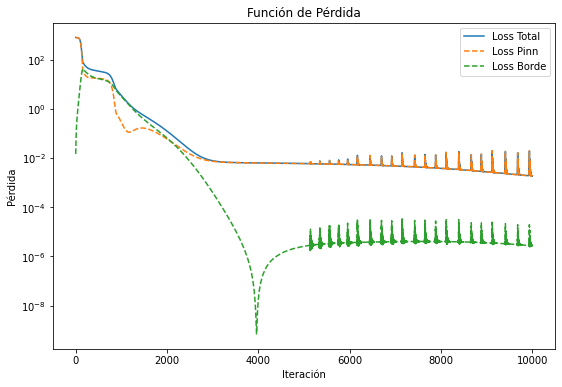

In [47]:
#gráfica pérdida
plt.figure(figsize=(9,6))

plt.plot(range(len(hist['loss'])), hist['loss'], label = 'Loss Total')
plt.plot(range(len(hist['loss_f'])), hist['loss_f'], label = 'Loss Pinn', linestyle = '--')
plt.plot(range(len(hist['loss_b'])), hist['loss_b'], label = 'Loss Borde', linestyle = '--')
plt.title('Función de Pérdida')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.show()

### Gráfica Solución

16/16 [==============================] - 0s 3ms/step


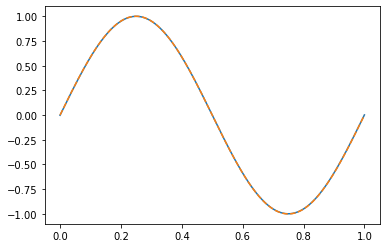

In [49]:
N = 500
xspace = np.linspace(xmin, xmax, N + 1)
u_real = np.sin(2.0*np.pi*xspace)
u_pred = model_1.predict(xspace)
plt.plot(xspace, u_pred, label = 'Predicción')
plt.plot(xspace, u_real, label = 'Real', linestyle = '--')